In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [67]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [68]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


# Understanding the problem label data

Understanding this correlation will help us how we should encode and fillup the respective features.Such as if some feature is very sparse and has weak correlation with sale price we will drop that feature.

In [69]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Lets try to understand the correlations with other variables

most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.13

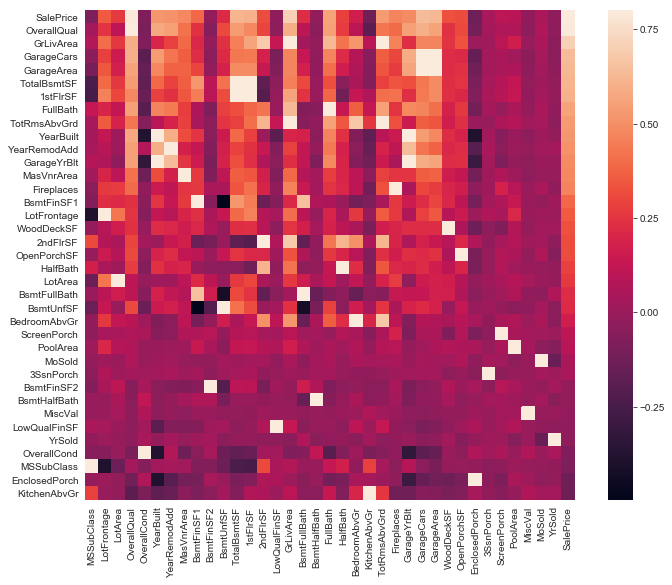

In [70]:
print("most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

# Dataset authur's recommended changes  
The author of the dataset recommends  removing any house more then 4000 sqfeet 

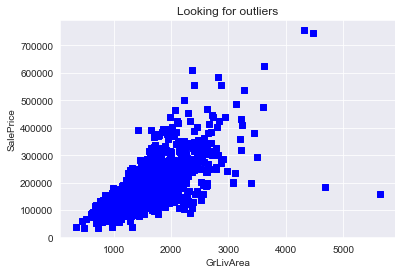

In [71]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

# Data set Concating

In [72]:
train_raw_labels = train['SalePrice'].to_frame().as_matrix()
ntrain = train.shape[0]
ntest = test.shape[0]
train["SalePrice_log"] = np.log1p(train["SalePrice"])
train_labels_with_OT=train["SalePrice_log"]
concated_dataset = pd.concat((train, test)).reset_index(drop=True)
concated_dataset.drop(['SalePrice','SalePrice_log'], axis=1, inplace=True)
nconcated=concated_dataset.shape[0]
print("Concated dataset shape",concated_dataset.shape,"train",train.shape,"test",test.shape)


Concated dataset shape (2915, 79) train (1456, 81) test (1459, 79)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Checking proper spliting

In [73]:
train_post = concated_dataset.iloc[0:1456,:]
test_post = concated_dataset.iloc[1456:2915,:]
print("train shape",train_post.shape)
print("test shape",test_post.shape)

train shape (1456, 79)
test shape (1459, 79)


In [74]:
Test=np.exp(train_labels_with_OT.values)
print(Test)

[208501. 181501. 223501. ... 266501. 142126. 147501.]


# Justifying my reason to take log of saleprice

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


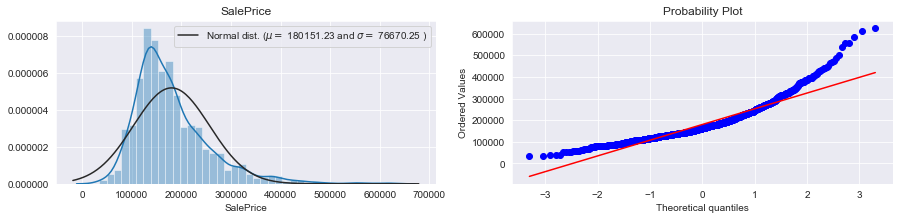

Skewness: 1.565959
Kurtosis: 3.885283


In [75]:
from scipy import stats
from scipy.stats import norm
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('SalePrice')

plt.subplot(122)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

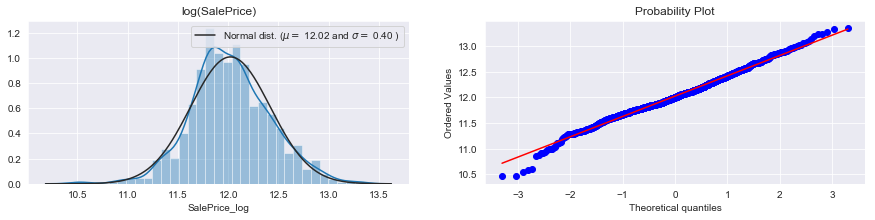

Skewness: 0.065460
Kurtosis: 0.666423


In [76]:
fig = plt.figure(figsize=(15,3))
plt.subplot(121)
sns.distplot(train_labels_with_OT , fit=norm);

(mu, sigma) = norm.fit(train_labels_with_OT)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.title('log(SalePrice)')

plt.subplot(122)
res = stats.probplot(train_labels_with_OT, plot=plt)
plt.show()
print("Skewness: %f" % train["SalePrice_log"].skew())
print("Kurtosis: %f" % train["SalePrice_log"].kurt())

# Checking for missing data and handling

In [77]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageQual,5.454545
GarageCond,5.454545
GarageFinish,5.454545
GarageYrBlt,5.454545


In [78]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset.loc[:, "Alley"] = concated_dataset.loc[:, "Alley"].fillna("None")
concated_dataset.loc[:, "BedroomAbvGr"] = concated_dataset.loc[:, "BedroomAbvGr"].fillna(0)
concated_dataset.loc[:, "BsmtQual"] = concated_dataset.loc[:, "BsmtQual"].fillna("No")
concated_dataset.loc[:, "BsmtCond"] = concated_dataset.loc[:, "BsmtCond"].fillna("No")
concated_dataset.loc[:, "BsmtExposure"] = concated_dataset.loc[:, "BsmtExposure"].fillna("No")
concated_dataset.loc[:, "BsmtFinType1"] = concated_dataset.loc[:, "BsmtFinType1"].fillna("No")
concated_dataset.loc[:, "BsmtFinType2"] = concated_dataset.loc[:, "BsmtFinType2"].fillna("No")
concated_dataset.loc[:, "BsmtFullBath"] = concated_dataset.loc[:, "BsmtFullBath"].fillna(0)
concated_dataset.loc[:, "BsmtHalfBath"] = concated_dataset.loc[:, "BsmtHalfBath"].fillna(0)
concated_dataset.loc[:, "BsmtUnfSF"] = concated_dataset.loc[:, "BsmtUnfSF"].fillna(0)
concated_dataset.loc[:, "CentralAir"] = concated_dataset.loc[:, "CentralAir"].fillna("N")
concated_dataset.loc[:, "Condition1"] = concated_dataset.loc[:, "Condition1"].fillna("Norm")
concated_dataset.loc[:, "Condition2"] = concated_dataset.loc[:, "Condition2"].fillna("Norm")
concated_dataset.loc[:, "EnclosedPorch"] = concated_dataset.loc[:, "EnclosedPorch"].fillna(0)
concated_dataset.loc[:, "ExterCond"] = concated_dataset.loc[:, "ExterCond"].fillna("TA")
concated_dataset.loc[:, "ExterQual"] = concated_dataset.loc[:, "ExterQual"].fillna("TA")
concated_dataset.loc[:, "Fence"] = concated_dataset.loc[:, "Fence"].fillna("No")
concated_dataset.loc[:, "FireplaceQu"] = concated_dataset.loc[:, "FireplaceQu"].fillna("No")
concated_dataset.loc[:, "Fireplaces"] = concated_dataset.loc[:, "Fireplaces"].fillna(0)
concated_dataset.loc[:, "Functional"] = concated_dataset.loc[:, "Functional"].fillna("Typ")
concated_dataset.loc[:, "GarageType"] = concated_dataset.loc[:, "GarageType"].fillna("No")
concated_dataset.loc[:, "GarageFinish"] = concated_dataset.loc[:, "GarageFinish"].fillna("No")
concated_dataset.loc[:, "GarageQual"] = concated_dataset.loc[:, "GarageQual"].fillna("No")
concated_dataset.loc[:, "GarageCond"] = concated_dataset.loc[:, "GarageCond"].fillna("No")
concated_dataset.loc[:, "GarageArea"] = concated_dataset.loc[:, "GarageArea"].fillna(0)
concated_dataset.loc[:, "GarageCars"] = concated_dataset.loc[:, "GarageCars"].fillna(0)
concated_dataset.loc[:, "HalfBath"] = concated_dataset.loc[:, "HalfBath"].fillna(0)
concated_dataset.loc[:, "HeatingQC"] = concated_dataset.loc[:, "HeatingQC"].fillna("TA")
concated_dataset.loc[:, "KitchenAbvGr"] = concated_dataset.loc[:, "KitchenAbvGr"].fillna(0)
concated_dataset.loc[:, "KitchenQual"] = concated_dataset.loc[:, "KitchenQual"].fillna("TA")
concated_dataset.loc[:, "LotFrontage"] = concated_dataset.loc[:, "LotFrontage"].fillna(0)
concated_dataset.loc[:, "LotShape"] = concated_dataset.loc[:, "LotShape"].fillna("Reg")
concated_dataset.loc[:, "MasVnrType"] = concated_dataset.loc[:, "MasVnrType"].fillna("None")
concated_dataset.loc[:, "MasVnrArea"] = concated_dataset.loc[:, "MasVnrArea"].fillna(0)
concated_dataset.loc[:, "MiscFeature"] = concated_dataset.loc[:, "MiscFeature"].fillna("No")
concated_dataset.loc[:, "MiscVal"] = concated_dataset.loc[:, "MiscVal"].fillna(0)
concated_dataset.loc[:, "OpenPorchSF"] = concated_dataset.loc[:, "OpenPorchSF"].fillna(0)
concated_dataset.loc[:, "PavedDrive"] = concated_dataset.loc[:, "PavedDrive"].fillna("N")
concated_dataset.loc[:, "PoolQC"] = concated_dataset.loc[:, "PoolQC"].fillna("No")
concated_dataset.loc[:, "PoolArea"] = concated_dataset.loc[:, "PoolArea"].fillna(0)
concated_dataset.loc[:, "SaleCondition"] = concated_dataset.loc[:, "SaleCondition"].fillna("Normal")
concated_dataset.loc[:, "ScreenPorch"] = concated_dataset.loc[:, "ScreenPorch"].fillna(0)
concated_dataset.loc[:, "TotRmsAbvGrd"] = concated_dataset.loc[:, "TotRmsAbvGrd"].fillna(0)
concated_dataset.loc[:, "Utilities"] = concated_dataset.loc[:, "Utilities"].fillna("AllPub")
concated_dataset.loc[:, "WoodDeckSF"] = concated_dataset.loc[:, "WoodDeckSF"].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'):
    concated_dataset[col] = concated_dataset[col].fillna(0)
concated_dataset['Exterior1st'] = concated_dataset['Exterior1st'].fillna(concated_dataset['Exterior1st'].mode()[0])
concated_dataset['Exterior2nd'] = concated_dataset['Exterior2nd'].fillna(concated_dataset['Exterior2nd'].mode()[0])
concated_dataset['SaleType'] = concated_dataset['SaleType'].fillna(concated_dataset['SaleType'].mode()[0])
concated_dataset['MSZoning'] = concated_dataset['MSZoning'].fillna(concated_dataset['MSZoning'].mode()[0])
concated_dataset['Electrical'] = concated_dataset['Electrical'].fillna(concated_dataset['Electrical'].mode()[0])


Justification for above choices is discussed below.Verify if any data is still missing.

In [79]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


Nothing  has  null 

# Visualize the distribution
before doing any thing else lets visualize the distribution. This looks good!

In [80]:
import math
color = sns.color_palette()
sns.set_style('darkgrid')

In [81]:
def plot_df_distributions(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes != 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*3.5,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            
            if col_idx < len(_columns):
                col = _columns[col_idx]
                sns.distplot(df[col], ax=axes[r_idx][c_idx], fit=norm)
    
    plt.tight_layout()
    plt.show()

In [82]:
def plot_df_countplots(df, num_cols=3, columns=None):
    if columns is None:
        _columns = df.loc[:,df.dtypes == 'object'].columns.values
    else:
        _columns = columns

    n_cols = num_cols
    n_rows = math.ceil(len(_columns)/n_cols)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3))

    for r_idx in range(n_rows):
        for c_idx in range(n_cols):
            col_idx = r_idx*3+c_idx
            if col_idx < len(_columns):
                col = _columns[col_idx]
                
                sns.countplot(df[col], ax=axes[r_idx][c_idx])
                axes[r_idx][c_idx].set_title(col)
                for item in axes[r_idx][c_idx].get_xticklabels():
                    item.set_rotation(45)
    
    plt.tight_layout()
    plt.show()

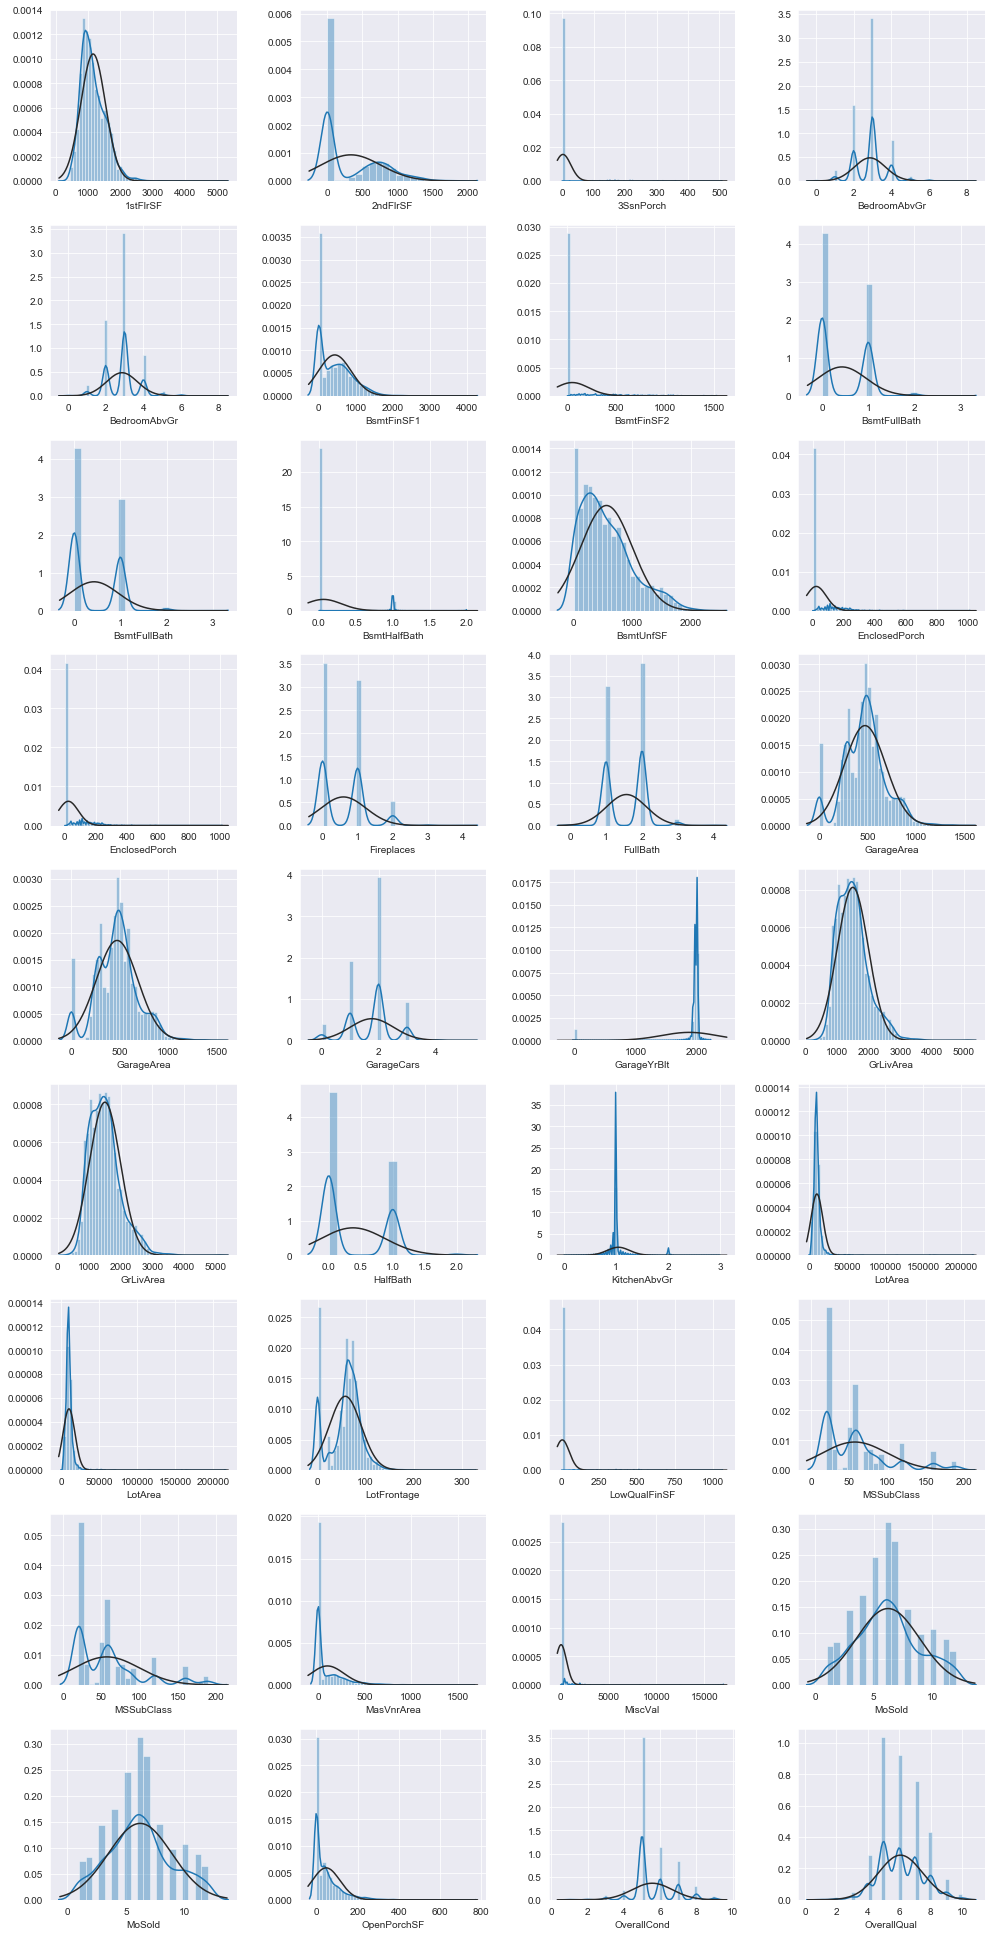

None

In [83]:
display(plot_df_distributions(concated_dataset, num_cols=4))


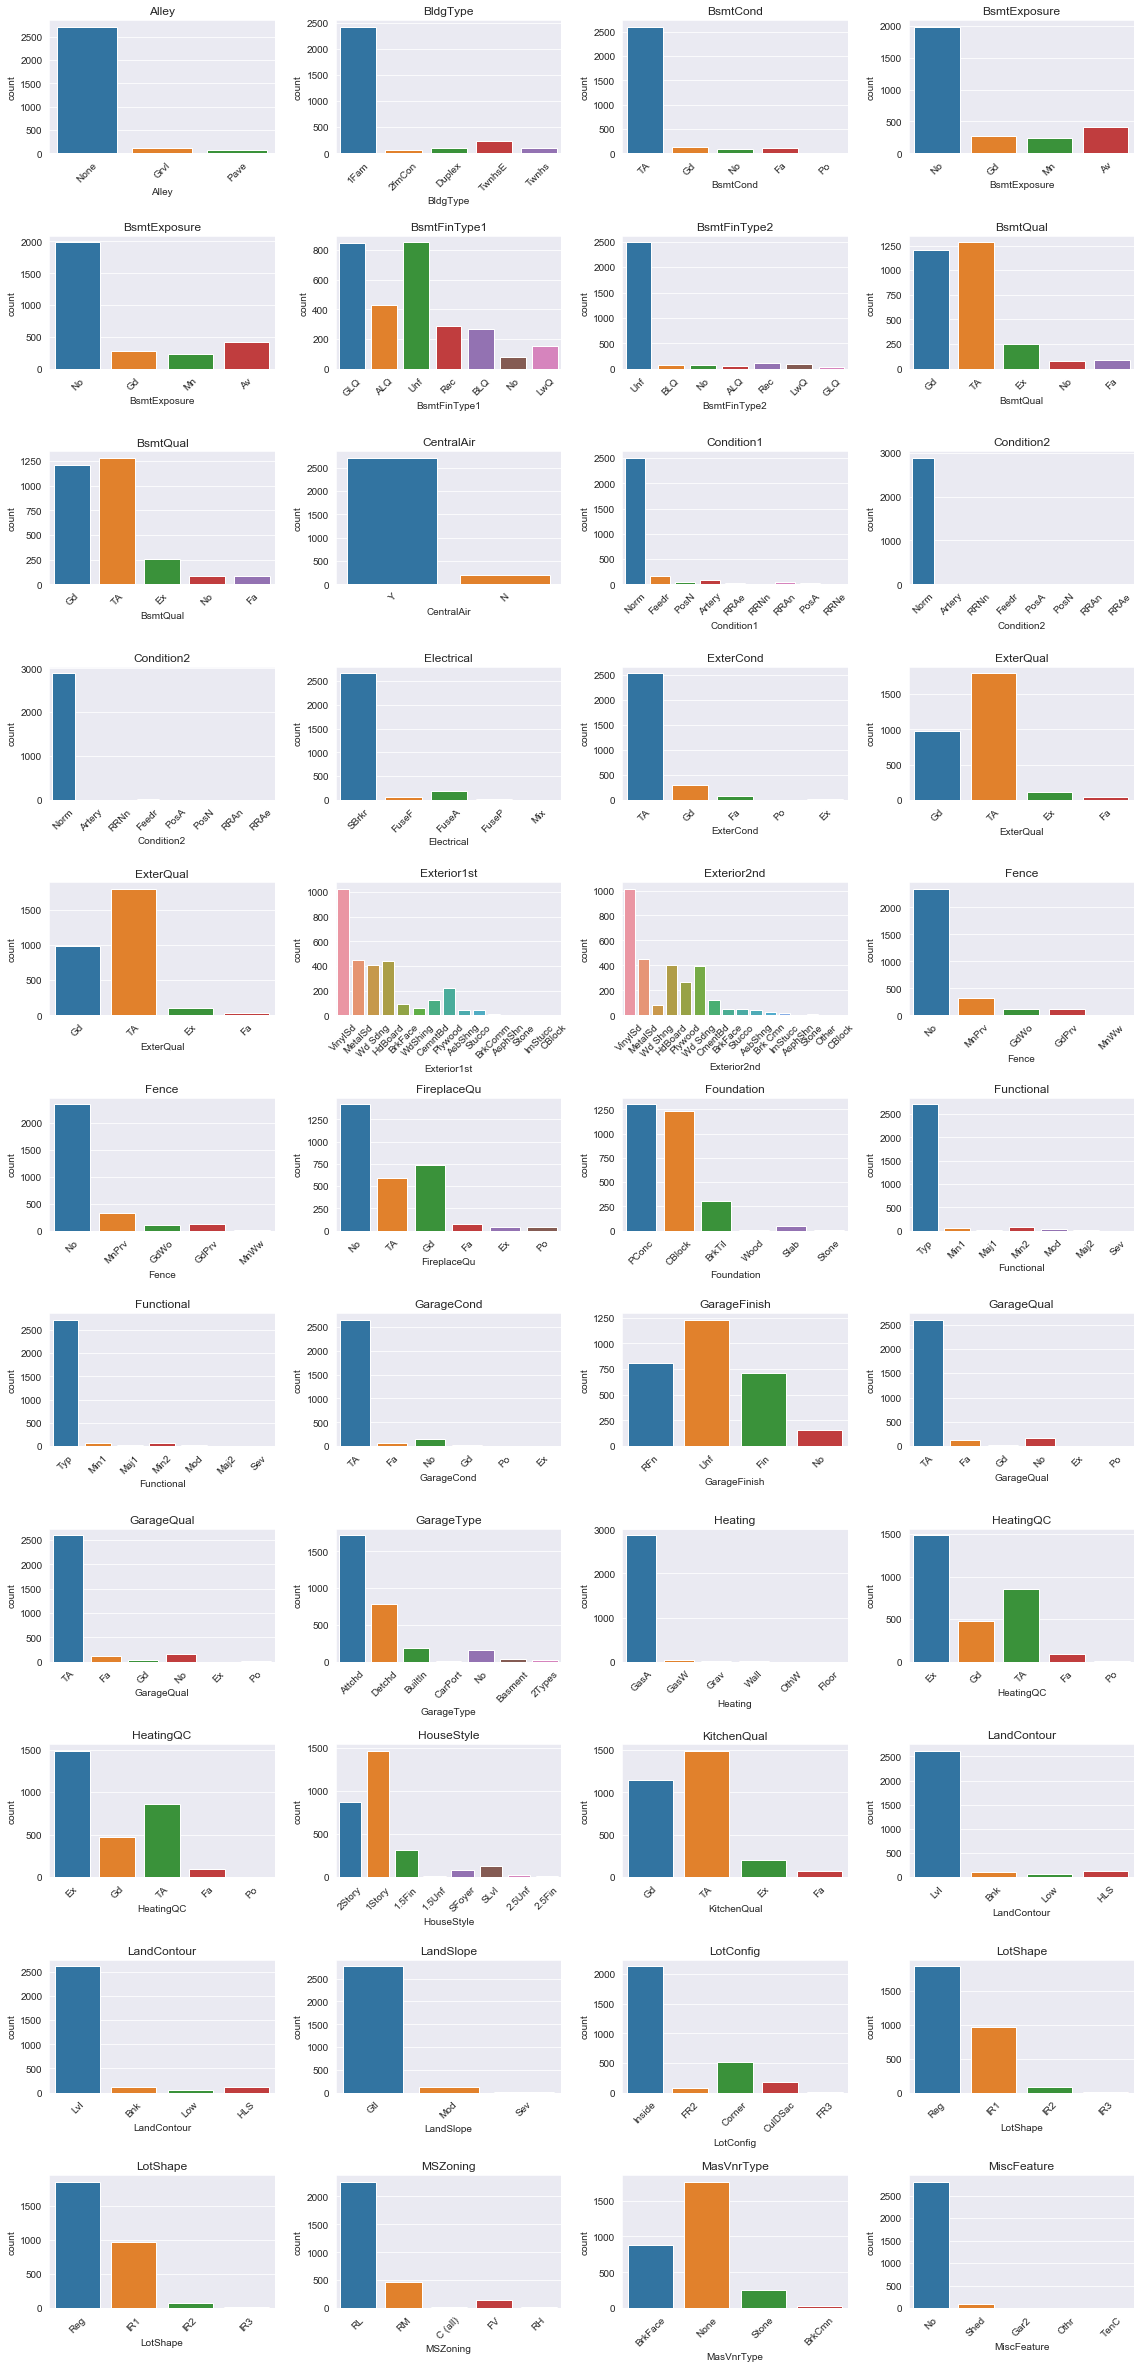

In [84]:
plot_df_countplots(concated_dataset, num_cols=4)


# Black List of feature
Some features are not balanced and badly effect the model. But we can't be sure about that right now.So let's make them black listed.If model is doing well without them we will simly drop them.

In [85]:
black_list=[]
black_list.append('Street')
black_list.append('Condition2')
black_list.append('RoofMatl')
black_list.append('Heating')
black_list.append('MiscVal')
black_list.append('Utilities')


# Add Features 
Lets add some new features. Those features are made out of prior experice on sloving that same problem.We have seen that simple applying One hot encoding and label encoding made our models performace stuck (public score=.24). So this time we will add some new features.


# Feature Encoding
For training through neural network our features must the in some numerical value. Since gradiantent decent algorithm (such as back propagation ) uses derivative to get optimised value of wights.Lets catagorize the the catgorical feature! 

In [86]:
# Some numerical features are actually really categories
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [87]:
# Encode some categorical features as ordered numbers when there is information in the order
concated_dataset = concated_dataset.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [88]:
concated_dataset = concated_dataset.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# 1.Feature  Engineering
Adding new featues showed some great improvement in accuracy

# 1.0 Simplified Feature
We will add some simplified version of existing feature

# 1.1 Combine Existing Feature
We will create and append some new feature. Those are creating from the existaing feature.

# 1.2 Double simpling
Now we will find the features which has most impact on target

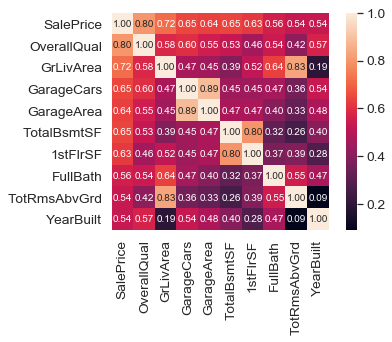

In [89]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Feature type Analysis

In [90]:
categorical_features = concated_dataset.select_dtypes(include = ["object"]).columns
numerical_features = concated_dataset.select_dtypes(exclude = ["object"]).columns
print(categorical_features)
print(numerical_features)
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
Numerical_feature=numerical_features.values


Index(['Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation',
       'GarageFinish', 'GarageType', 'Heating', 'HouseStyle', 'LandContour',
       'LotConfig', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'EnclosedPorch', 'ExterCond', 'ExterQual', 'FireplaceQu', 'Fireplaces',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageQual', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'HeatingQC',
       'KitchenAbvGr', 'KitchenQual', 'LandSlope', 'LotArea', 'LotFrontage',
       'LotShape', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'Op

# Label Encoding


In [91]:
concated_dataset_num = concated_dataset[numerical_features]
concated_dataset_cat = concated_dataset[categorical_features]


We created some new features. Those might be sparse. So filling those up. 

In [92]:
print("NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))
concated_dataset_num = concated_dataset_num.fillna(concated_dataset_num.median())
print("Remaining NAs for numerical features in train : " + str(concated_dataset_num.isnull().values.sum()))

NAs for numerical features in train : 0
Remaining NAs for numerical features in train : 0


In [93]:
concated_null = (concated_dataset.isnull().sum() / len(concated_dataset)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


In [94]:
from sklearn.preprocessing import LabelEncoder
for c in categorical_features:
    lbl = LabelEncoder() 
    lbl.fit(list(concated_dataset[c].values)) 
    concated_dataset[c] = lbl.transform(list(concated_dataset[c].values))


# Explaination for above choices
choices for fiiling missing data and replacement

From the list we can begin working with data filling.First let check what is PoolQC and why this is empthy.This have four values Ex=Excellent,Gd=Good,TA=typical,Fa=Fair,NA=no pool.So may be missing data should be NA.Lets also help our model by just replacing with neumerical values I will give Ex=4 and No Pool=0. Since the saleprice should be higher if the PoolQC is more.

Now this looks good. Now we can investigate next feature. Which MiscFeature is 96% missing data.This has Elev {Elevator}, Gar2 {2nd Garage} ,Othr {Other},Shed {Shed (over 100 SF}TenC {Tennis Court},NA   {None} values.But we can but keep NA lets replace. We also need to make it catagorical at some point.This feature is also black listed.

Now lets fill up Alley.This can be of 3 types Gravel, paved and No Alley which means NA will have different meaning.We will one hot encode that.

Lets encode time like feature.Well we should one hot encode those but lets's see how it helps if we let it behave like neumerical feature 

Now lets find out how to encode fireplace. From the descreption Ex Excellent - Exceptional Masonry Fireplace Gd Good - Masonry Fireplace in main level TA Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement Fa Fair - Prefabricated Fireplace in basement Po Poor - Ben Franklin Stove NA No Fireplace So we can replace Ex with 5 and NA with 0.

LotFrontage: Linear feet of street connected to property.NA probably means not given. LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

GarageType, GarageFinish, GarageQual, GarageCond is NA if no Garage is there. NA should be replaced with None.I will fill up maually.

Lets's keep a list of things we can't decide where it is ranked or not.


In [95]:
Undecided_ranked=[]
Undecided_unranked=[]
Undecided_unranked.append("Functional")
Undecided_unranked.append("Alley")
Undecided_unranked.append("BsmtFin1")
Undecided_unranked.append("Bsmtfin2")
Undecided_ranked.append("Fence")

In [96]:
Undecided_ranked.append("PavedDrive")

LotShape: General shape of property
       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
Does general shape better then Irregular.Not always may be fency Irregular shape is more costly.For now manulay encode that but adding to undeceded list for future experiment.

In [97]:
Undecided_ranked.append("LandSlope")
Undecided_ranked.append("LotShape")

Adding simplified version of existing feature.

Let's take unorder catagorical data to str. So that we can use pd dummy to one hot encode. 

# Searching skewness
Neural network works best when it distribution is taken from normal distribution. Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.

In [98]:
from scipy.stats import skew
feature_skewness = concated_dataset[Numerical_feature].apply(lambda x: skew(x.dropna()))
feature_skewness = feature_skewness.sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : feature_skewness})
skewness.head(10)

,Skew
MiscVal,21.932147
PoolQC,21.906328
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508


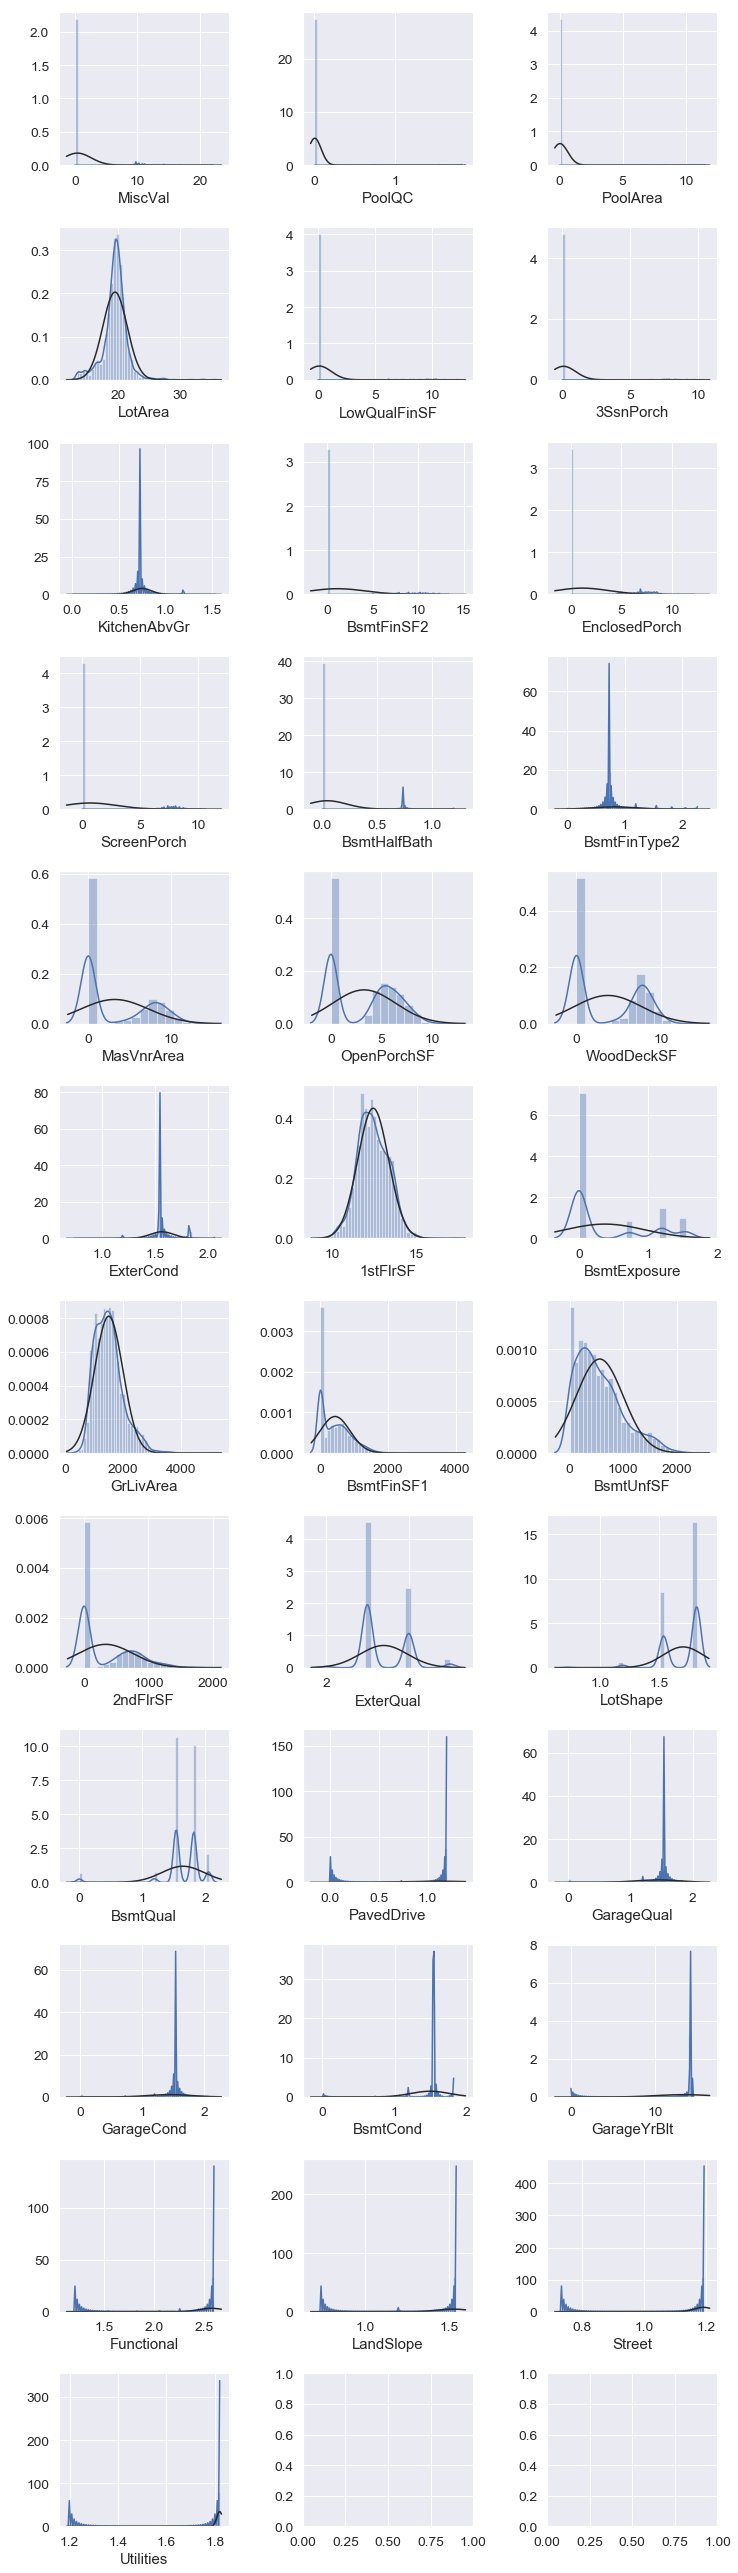

In [101]:
high_skewed_features = skewness.loc[abs(skewness.Skew) >= 0.75].index.values
plot_df_distributions(concated_dataset, columns=high_skewed_features)

# Fixing skewness with Boxcox transformation
A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a test which works well in normal distribution. Such as Neural netork regressors.

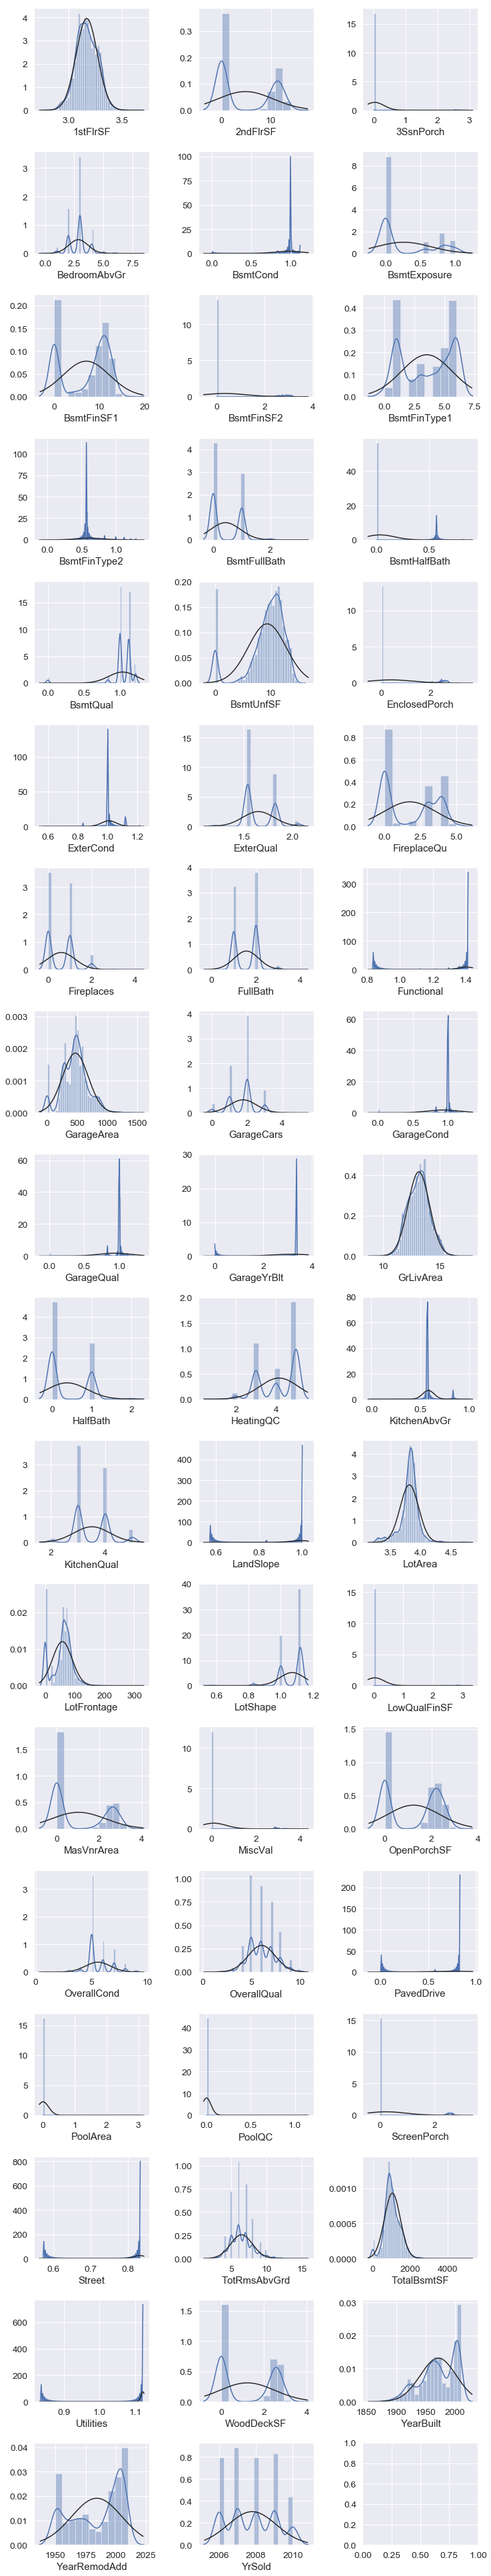

In [102]:
from scipy.special import boxcox1p

lam = 0.15
for feat in high_skewed_features:
    concated_dataset[feat] = boxcox1p(concated_dataset[feat], lam)
    
plot_df_distributions(concated_dataset, columns=Numerical_feature)

# Standard Scaling


In [103]:
from sklearn.preprocessing import StandardScaler
Std_nummerical = StandardScaler()
Std_nummerical.fit(concated_dataset[Numerical_feature])
concated_dataset[Numerical_feature] = Std_nummerical.transform(concated_dataset[Numerical_feature])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [137]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.99)
concated_dataset_reduced=pca.fit_transform(concated_dataset)


In [138]:
print(pca.explained_variance_ratio_)

[0.23082801 0.14114832 0.1021914  0.07053136 0.06241311 0.0274046
 0.02378914 0.0201694  0.0172402  0.01648839 0.0162911  0.01314255
 0.01235606 0.0113026  0.01060711 0.01017309 0.00958913 0.00923434
 0.0082218  0.00776366 0.00756286 0.00737148 0.00700038 0.00684061
 0.00673977 0.00654434 0.00637937 0.0062295  0.00614733 0.00600121
 0.00589672 0.00573366 0.00546539 0.00534219 0.00513695 0.00505724
 0.00491736 0.00478084 0.00433057 0.00413831 0.00405788 0.00377752
 0.00371666 0.00350756 0.0033944  0.00327942 0.00315516 0.00261565
 0.002557   0.00239874 0.00228554 0.00223821 0.00200373 0.00196447
 0.0019184  0.00170972 0.00160327 0.00155188 0.00150747 0.00148387
 0.00129919]


# Minmax Scaling
Minmax normalization is a normalization strategy which linearly transforms x to y= (x-min)/(max-min), where min and max are the minimum and maximum values in X, where X is the set of observed values of x. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


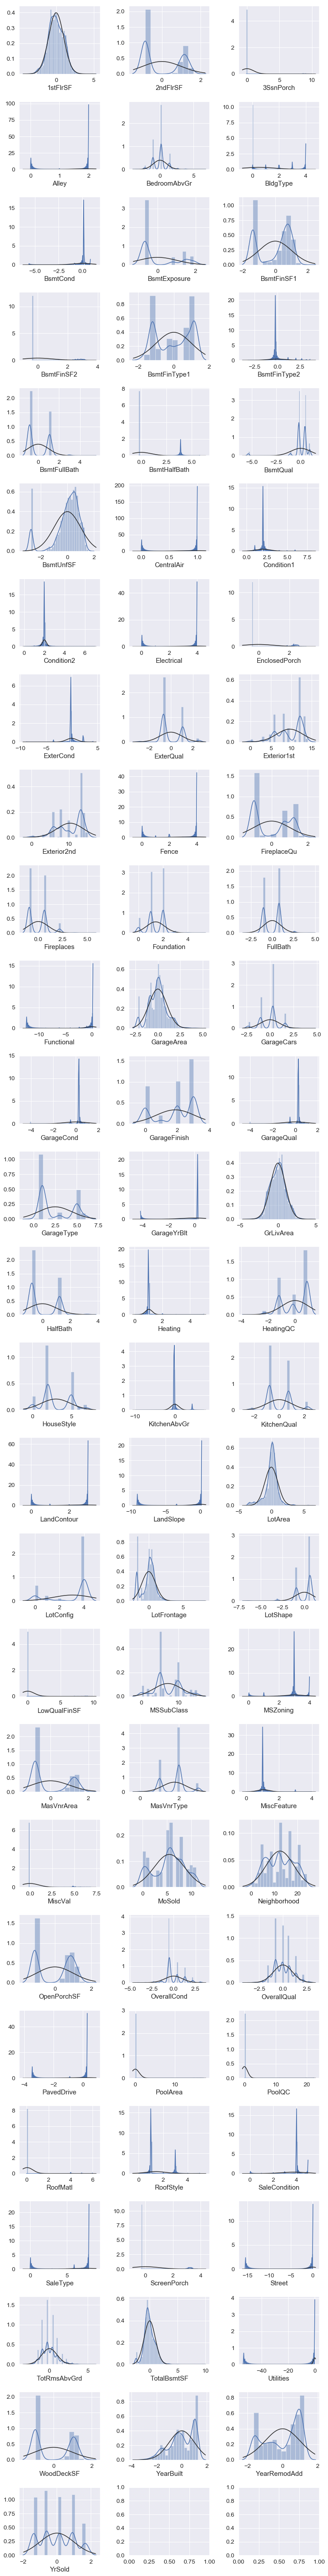

In [105]:
plot_df_distributions(concated_dataset)


# Preparing for One Hot encoding
In order to make unordered catagories represented in one hot encoding with pandas dummies we have to make the feature object type first.

# Removing Black listed features
This is experimental if it this does not help the model. We will undo that.

In [106]:
concated_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.775823,1.217185,-0.113116,2,0.170991,0,0.174254,-0.665428,0.803260,-0.365175,...,8,-0.309852,0.064294,0.995259,-0.448619,0.018525,-0.949886,1.047630,0.897853,0.157001
1,0.435976,-0.858991,-0.113116,2,0.170991,0,0.174254,1.897062,0.977559,-0.365175,...,8,-0.309852,0.064294,-0.285332,0.499890,0.018525,1.194592,0.156123,-0.394399,-0.603230
2,-0.549613,1.224009,-0.113116,2,0.170991,0,0.174254,0.797887,0.613830,-0.365175,...,8,-0.309852,0.064294,-0.285332,-0.299101,0.018525,-0.949886,0.981592,0.849992,0.157001
3,-0.413081,1.158185,-0.113116,2,0.170991,0,0.881671,-0.665428,0.237682,-0.365175,...,8,-0.309852,0.064294,0.354963,-0.682242,0.018525,-0.949886,-1.858022,-0.681566,-1.363461
4,0.133612,1.321148,-0.113116,2,1.386699,0,0.174254,1.469900,0.764358,-0.365175,...,8,-0.309852,0.064294,1.635554,0.226551,0.018525,1.080067,0.948573,0.754269,0.157001


# One hot encoding
by Pandas dummy variable

# Splitting Data back to Train and Test set

In [107]:
train_postprocess=concated_dataset_reduced[0:1456]
print("train shape",train_postprocess.shape)
test_postprocess = concated_dataset_reduced[1456:2915]
print("test shape",test_postprocess.shape)

train shape (1456, 61)
test shape (1459, 61)


# Removing Out layers
We will use simple isolation Forest to remove outlayers.In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using  random partitioning like in isolation tree or any decession tree, they should be identified closer to the root of the tree (shorter average path length) with fewer splits necessary.

# 0. Processing data for feeding NN
Usually float32 formated data is feed to neural network so that it can calculate small numbers without any round off or truncation error.  

In [139]:
#PCA style  preprocessing
x_train = train_postprocess.astype(np.float32)
x_train.shape

(1456, 61)

In [140]:
y_train = train_labels_with_OT.values.astype(np.float32)
y_train.shape

(1456,)

In [141]:
Test=np.expm1(y_train)

print(Test)

[208499.94 181500.   223499.98 ... 266500.06 142125.03 147500.02]


In [142]:
x_test = test_postprocess.astype(np.float32)
x_test.shape

(1459, 61)

# 1.1 Splitting Training set to valid-train set 
To understand how our model is doing we must have some validation set. We will check performance on every 100 epoch on validation set. We have also implemented early stoping.Uff!! We took 25% validation set.

In [122]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(x_train, y_train, test_size=0.3, random_state=40)

1.2 keeping some important shapes in variables for ease of use

In [123]:
m_train,n_train=X_train_val.shape
m_val,n_val=X_test_val.shape
m_test,n_test=x_test.shape

# Importing Libraries 
We imported data time to save check points

In [124]:
import tensorflow as tf
from datetime import datetime


In [125]:
#scalling and adding bias

scaled_x_train_plus_bias = np.c_[np.ones((m_train, 1)),X_train_val]
scaled_x_val_plus_bias = np.c_[np.ones((m_val, 1)),X_test_val]
scaled_x_test_plus_bias = np.c_[np.ones((m_test, 1)),x_test]


In [128]:
# hidden layers neuron numbers, batchsize and epoch number
tf.reset_default_graph()

n_inputs = n_train+1
n_hidden1 = 16
n_hidden2 = 111
n_hidden3=55
n_hidden4=13
n_hidden5=8
n_hidden6=4
n_outputs = 1
n_epochs = 15000 
batch_size = 100


In [129]:
#Learning rate with schedular
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

In [130]:
#Place holder initiallizations
X = tf.placeholder(tf.float32,shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32,shape=(None), name="y")

In [131]:
#Drop out initializations ,tunable per layer wise 
training = tf.placeholder_with_default(False, shape=(), name='training')
dropout_rate_X = 0.1
dropout_rate_1=0.2
dropout_rate_2=0.2
dropout_rate_3=0.2
dropout_rate_4=0.0
dropout_rate_5=0.0
dropout_rate_6=0.0
X_drop = tf.layers.dropout(X, dropout_rate_X, training=training)
he_init = tf.variance_scaling_initializer()

In [132]:
#max norn fuctions

def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

#Threshold tuning option
max_norm_reg = max_norm_regularizer(threshold=1.0)


In [78]:
#Batch normalizaion function and He initializer
from functools import partial
batch_norm_momentum=0.9

he_init = tf.variance_scaling_initializer()

Custom_batch_normalized_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

Custum_dense_layer = partial(
            tf.layers.dense,
            kernel_regularizer=max_norm_reg)

In [79]:


with tf.name_scope("dnn"):
    
    #layer1
    hidden1 = Custum_dense_layer(X_drop, n_hidden1,name="hidden1")
    bn1 =  Custom_batch_normalized_layer(hidden1)
    hidden1_bn = tf.nn.elu(bn1)
    hidden1_drop = tf.layers.dropout(hidden1_bn, dropout_rate_1, training=training)
    
    #layer2
    hidden2 =Custum_dense_layer(hidden1_drop, n_hidden2,name="hidden2")
    bn2 = Custom_batch_normalized_layer(hidden2)
    hidden2_bn = tf.nn.elu(bn2)
    hidden2_drop = tf.layers.dropout(hidden2_bn, dropout_rate_2, training=training)
   
   
    #output
    y_pred_before_BN = Custum_dense_layer(hidden2_drop,n_outputs,name="outputs")
    y_pred=Custom_batch_normalized_layer( y_pred_before_BN)








In [80]:
#Loss calculation and optimizer
error=y_pred-y
mse = tf.reduce_mean(tf.square(error),name="mse")




with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(mse,global_step=global_step)

init = tf.global_variables_initializer()

In [81]:
#batch making and shuffling
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [82]:
#Clipping gradient and saver object
saver = tf.train.Saver()
clip_all_weights=tf.get_collection("max_norm")

In [83]:
#Session with Early stopping mechanism

max_checks_without_progress = 4000
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(scaled_x_train_plus_bias, y_train_val, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            #sess.run(clip_all_weights)

        loss_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias, y: y_test_val})
        
        
        #Check whether to stop or not
        if loss_val < best_loss:
            save_path = saver.save(sess,"./Final_Certairi.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        #printing at run time
        if epoch %100==0:
            acc_batch = mse.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mse.eval(feed_dict={X: scaled_x_val_plus_bias, y: y_test_val})
            
            
            
            print("Epoch_number",epoch, "Batch error:", acc_batch, "Val error:", acc_val)
    pred=y_pred.eval(feed_dict={X: scaled_x_test_plus_bias})

                
with tf.Session() as sess:
    saver.restore(sess, "./Final_Certairi.ckpt")


Epoch_number 0 Batch error: 14.057663 Val error: 11.511307
Epoch_number 100 Batch error: 0.12666291 Val error: 0.19294323
Epoch_number 200 Batch error: 0.18025905 Val error: 0.24553777
Epoch_number 300 Batch error: 0.1368131 Val error: 0.18645468
Epoch_number 400 Batch error: 0.12701191 Val error: 0.17947724
Epoch_number 500 Batch error: 0.111357145 Val error: 0.14724371
Epoch_number 600 Batch error: 0.1159636 Val error: 0.14069138
Epoch_number 700 Batch error: 0.117962055 Val error: 0.13759859
Epoch_number 800 Batch error: 0.14825155 Val error: 0.1502872
Epoch_number 900 Batch error: 0.10123013 Val error: 0.1439431
Epoch_number 1000 Batch error: 0.12184509 Val error: 0.13714975
Epoch_number 1100 Batch error: 0.12099194 Val error: 0.13833664
Epoch_number 1200 Batch error: 0.13320796 Val error: 0.13639334
Epoch_number 1300 Batch error: 0.116755195 Val error: 0.13557272
Epoch_number 1400 Batch error: 0.14869344 Val error: 0.15964709
Epoch_number 1500 Batch error: 0.12671861 Val error: 0.

In [84]:
pred_non_expo=np.expm1(pred)
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = pred_non_expo

sub.to_csv('Submission.csv',index=False)

# Simple DNN for debugging

In [50]:
learning_rate = 0.1 
num_steps =7500
beta = .005
hidden_1 = 16 
hidden_2 = 8
hidden_3 = 4 
input_dim = x_train.shape[1]
output_dim = 1  
X_tf = tf.placeholder("float" ) 
y_tf = tf.placeholder("float" ) 

In [51]:
weights = {'w1': tf.Variable(tf.random_normal([input_dim, hidden_1])),  
           'w2': tf.Variable(tf.random_normal([hidden_1, hidden_2])),  
           'w3': tf.Variable(tf.random_normal([hidden_2, hidden_3])), 
           'out': tf.Variable(tf.random_normal([hidden_3, output_dim ])) }

biases = {'b1': tf.Variable(tf.random_normal([hidden_1])),
          'b2': tf.Variable(tf.random_normal([hidden_2])),
          'b3': tf.Variable(tf.random_normal([hidden_3])),
          'out': tf.Variable(tf.random_normal([output_dim])) } 

In [52]:
 def ann_model(X_val): 
        layer_1 = tf.add(tf.matmul(X_val, weights['w1']), biases['b1' ]) 
        layer_1 = tf.nn.relu(layer_1) 
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2) 
        layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']) 
        layer_3 = tf.nn.relu(layer_3)
        layer_out = tf.add(tf.matmul(layer_3, weights['out']), biases ['out']) 
        return layer_out 

In [53]:
# Model Construct 
model = ann_model(X_tf) 
# Mean Squared Error cost function
cost = tf.reduce_mean(tf.square(y_tf - model)) 
regularizer_1 = tf.nn.l2_loss(weights['w1']) 
regularizer_2 = tf.nn.l2_loss(weights['w2']) 
regularizer_3 = tf.nn.l2_loss(weights['w3']) 
cost = tf.reduce_mean(cost + beta*regularizer_1 + beta*regularizer_2 
                      + regularizer_3)

In [54]:
# Adam optimizer will update weights and biases after each step 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) .minimize(cost)

In [55]:
# Initialize variables 
init = tf.global_variables_initializer() 

In [56]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver() 

In [57]:
 with tf.Session() as sess: 
        sess.run(init) 
        for i in range(num_steps): 
            sess.run(optimizer, feed_dict={X_tf:x_train, y_tf:y_train})  
            if (i+1)%100 == 0: 
                 print("batch no : ",i+1) 
        save_path = saver.save(sess, "/tmp/model.ckpt") 
        print("Model saved in path: %s" % save_path) 
        pred = sess.run(model, feed_dict={X_tf: x_test}) 


batch no :  100
batch no :  200
batch no :  300
batch no :  400
batch no :  500
batch no :  600
batch no :  700
batch no :  800
batch no :  900
batch no :  1000
batch no :  1100
batch no :  1200
batch no :  1300
batch no :  1400
batch no :  1500
batch no :  1600
batch no :  1700
batch no :  1800
batch no :  1900
batch no :  2000
batch no :  2100
batch no :  2200
batch no :  2300
batch no :  2400
batch no :  2500
batch no :  2600
batch no :  2700
batch no :  2800
batch no :  2900
batch no :  3000
batch no :  3100
batch no :  3200
batch no :  3300
batch no :  3400
batch no :  3500
batch no :  3600
batch no :  3700
batch no :  3800
batch no :  3900
batch no :  4000
batch no :  4100
batch no :  4200
batch no :  4300
batch no :  4400
batch no :  4500
batch no :  4600
batch no :  4700
batch no :  4800
batch no :  4900
batch no :  5000
batch no :  5100
batch no :  5200
batch no :  5300
batch no :  5400
batch no :  5500
batch no :  5600
batch no :  5700
batch no :  5800
batch no :  5900
batch 

In [58]:
 prediction = np.expm1(pred) 
 print(prediction)

[[166292.11]
 [166310.36]
 [166371.27]
 ...
 [166345.25]
 [166313.2 ]
 [166411.73]]


In [59]:
sub = pd.DataFrame()

sub['Id'] = test_ID
sub['SalePrice'] = prediction

sub.to_csv('submission_SDNN',index=False)

Improvemnt but still it should be much better.This above mentioned model is highly flexible and can be tune according to necessary.We can have a exhustive search on top of that.For both of the models I used Max norm normalization and dropout as regularizer.Kernel is regularized with batch normalization and initialized by he initialization.Dropout rates can be tuned per layer.As activation fuction I used elu instead of relu. This model checks for improvement in validation set for 2000 step if no improvement is found the model stops the training.Since the model is so flexible the next step can be to search over the entire parameter spaces using oscar,randomsearchCV or Grid Search.Lastly, This is pretty strong model and made without any prior on data preprocessing so better result can be achived with strong data preprocessing knowledge.

# Reference